In [4]:
# import sys
#!{sys.executable} -m pip install qiskit
#!{sys.executable} -m pip install qiskit-nature

In [5]:
%load_ext autoreload
%autoreload 2
from pfapack import pfaffian as pf

from sys import path as syspath
from os import path as ospath
# /!\ import here https://github.com/mrfanuel/qiskit-nature


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
from numpy import linalg as LA

import matplotlib.pyplot as plt

import qiskit as qk
from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian
from qiskit_nature.second_q.circuit.library import FermionicGaussianState
from qiskit import Aer
import utilities
import pandas as pd

Definition of the Hamiltonian quadratic form

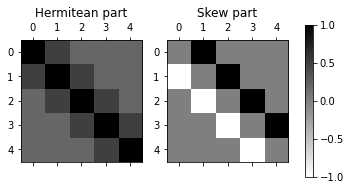

In [7]:
# create Hamiltonian quadratic form
hermitian_part = (-1)*np.array(
    [
        [1.0, 0.5, 0.2, 0.2, 0.2],
        [0.5, 1.0, 0.5, 0.2, 0.2],
        [0.2, 0.5, 1.0, 0.5, 0.2],
        [0.2, 0.2, 0.5, 1.0, 0.5],
        [0.2, 0.2, 0.2, 0.5, 1.0],
    ]
)
# create Hamiltonian quadratic form
hermitian_part = (-1)*np.array(
    [
        [1.0, 0.5, 0.2, 0.2, 0.2],
        [0.5, 1.0, 0.5, 0.2, 0.2],
        [0.2, 0.5, 1.0, 0.5, 0.2],
        [0.2, 0.2, 0.5, 1.0, 0.5],
        [0.2, 0.2, 0.2, 0.5, 1.0],
    ]
)
# Note the extra minus to match paper's convention

N = hermitian_part.shape[0]

antisymmetric_part = (-1)*np.array(
    [
        [0.0, 1.0, 0.0, 0.0, 0.0],
        [-1.0, 0.0, 1.0, 0.0, 0.0],
        [0.0, -1.0, 0.0, 1.0, 0.0],
        [0.0, 0.0, -1.0, 0.0, 1.0],
        [0.0, 0.0, 0.0, -1.0, 0.0],
    ]
)
# Note the extra minus to match paper's convention

# Hamiltonian quadratic form in the paper is H_BdG
# where H_BdG = C H_code 
# with H_code being the Hamiltonian quadratic form in the code
H_code = np.block([
    [hermitian_part,antisymmetric_part],
    [-antisymmetric_part.conj(), -hermitian_part.conj()]
])
# The only difference is a flip of the first and second rows of blocks.
# The operator in the paper is 
#   (c c^*) H_BdG (c^*\\ c) 
# and it is equal to the operator in the code
#   (c^* c) H_code (c^*\\ c)

# plotting
fig, ax = plt.subplots(1, 2)
vmin = -1
vmax = 1
cmap_str = "binary"

ax[0].matshow(-hermitian_part, cmap=cmap_str, vmin=vmin, vmax=vmax)
# minus sign to match the paper convention
ax[0].set_title("Hermitean part")

im = ax[1].matshow(-antisymmetric_part, cmap=cmap_str, vmin=vmin, vmax=vmax)
# minus sign to match the paper convention
ax[1].set_title("Skew part")
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.7)
plt.savefig('../fig/pfpp_M_Delta.pdf', bbox_inches='tight')
plt.show()

Decomposition of the Hamiltonian quadratic form

In [8]:
constant = 0.0
hamiltonian = QuadraticHamiltonian(
    hermitian_part=hermitian_part,
    antisymmetric_part=antisymmetric_part,
    constant=constant,
)
# get the transformation matrix W and orbital energies {epsilon_j}
(
    transformation_matrix,
    orbital_energies,
    transformed_constant,
) = hamiltonian.diagonalizing_bogoliubov_transform()

# transformation_matrix is the first row of the W matrix
print(f"Shape of transformation_matrix: {transformation_matrix.shape}")
print(f"Transformed constant: {transformed_constant}")
print(f"Eigenvalues: {orbital_energies}")

Shape of transformation_matrix: (5, 10)
Transformed constant: -6.606809791177379
Eigenvalues: [0.64607428 1.23626252 1.91280529 1.97054727 2.44793022]


Testing the decomposition of the Hamltonian matrix

In [9]:
# construct full W from its first row of blocks
W_up = transformation_matrix
W_1 = W_up[:, :N]
W_2 = W_up[:, N:]

W_down = np.block([
    [W_2.conj(),W_1.conj()]
])
W = np.block([
    [W_up],
    [W_down]
])

# diagonal with energies
Dplus = np.diag(orbital_energies)

Z = np.zeros_like(Dplus)
D = np.block([
    [Dplus,Z],
    [Z, -Dplus]
])

H_code_factorized = np.dot(W.conj().T , np.dot(D , W)) 
print(f"diagonalization: | H - W^* D W | = {LA.norm(H_code_factorized - H_code)}")
print(f"unitarity: | I - W^*  W | = {LA.norm(np.dot(W.conj().T ,W) - np.eye(2*N))}")


diagonalization: | H - W^* D W | = 5.896494433959332e-15
unitarity: | I - W^*  W | = 3.770394684527556e-15


Construction of the Pfaffian kernel

In [10]:
# we simulate the state b_1^* b_2^* b_3^* |0>

#occupied_orbitals = [0,1,2,3] # not an L-ensemble
occupied_orbitals = [0,1,2] # L-ensemble
#occupied_orbitals = [0,1] # not an L-ensemble

# the S matrix corresponds to
# <c_i c_j^*> <c_i c_j> 
# <c_i^* c_j^*> <c_i^* c_j> 

# Note that the definition of S does not depend of how the Hamiltonian quadratic form was defined

# S = W^T Diag(ind_minus, ind_plus) W.conj

# construct Diag(ind_minus, ind_plus)
ind_plus = np.zeros_like(orbital_energies)

for e in list(occupied_orbitals):
    ind_plus[e] = 1

ind_minus = 1 - ind_plus
ind = np.concatenate((ind_minus,ind_plus))
d_ind = np.diag(ind)

# construct S
S = np.dot(W.T,np.dot(d_ind, W.conj()))
# S = [I-K^T P^*\\
#      P       K]
# find the blocks

One = np.eye(N)
Z = np.zeros_like(One)

C = np.block([
    [Z, One],
    [One ,Z]
])

print(f"particle-hole on S: | C*S*C - I + S.conj | = {LA.norm(np.dot(C,np.dot(S,C)) - np.eye(2*N) + S.conj())}")

K = S[N:,N:]
P = S[N:,:N]

# define matrix with 2-point function off-diag 
# and 1-point function diag
rho_2 = np.zeros_like(K.real)
for i in range(N):
    for j in range(N):
        if i == j:
            rho_2[i,i] = np.real(K[i,i])
        else:
            rho_2[i,j] = np.real(K[i,i] * K[j,j] - K[i,j] * K[i,j].conj() + P[i,j] * P[i,j].conj())

particle-hole on S: | C*S*C - I + S.conj | = 3.7469161378470144e-15


Pfaffian kernel


In [19]:
pfK = np.zeros((2*N,2*N), dtype=complex)
for i in range(N):
    for j in range(N):
        pfK[2*i,2*j] = P[i,j]
        pfK[2*i,2*j + 1] = K[i,j]
        pfK[2*i + 1,2*j] = -K[j,i]
        pfK[2*i + 1,2*j + 1] = -P[i,j].conj()
        
J = np.zeros((2*N,2*N), dtype=complex)
for i in range(N):
    J[2*i,2*i + 1] = 1
    J[2*i + 1,2*i] = -1


print(f"cond nb of pfK-J: = {LA.cond(pfK-J)}")
print(f"testing invertibility of pfK-J: | (pfK-J)*(pfK-J)^{-1} - I | = {LA.norm(np.eye(2*N) - np.dot(pfK-J,LA.inv(pfK-J)))}")

# Likelihood matrix
L = LA.inv(pfK-J) - J
L = 0.5*(L - L.T) 


cond nb of pfK-J: = 11.431288995060147
testing invertibility of pfK-J: | (pfK-J)*(pfK-J)^-1 - I | = 1.8253574434583455e-15
parity 1st method: = 0.9999999999999993


plotting K and P kernels

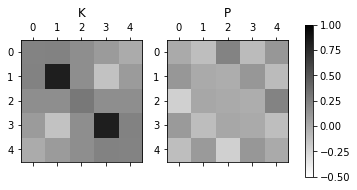

In [12]:
fig, ax = plt.subplots(1, 2)
vmin = -0.5
vmax = 1
cmap_str = "binary"

ax[0].matshow(K.real, cmap=cmap_str, vmin=vmin, vmax=vmax)
ax[0].set_title("K")

im = ax[1].matshow(P.real, cmap=cmap_str, vmin=vmin, vmax=vmax)
ax[1].set_title("P")
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.7)

plt.savefig('../fig/pfpp_K_P.pdf', bbox_inches='tight')
plt.show()

define the circuit

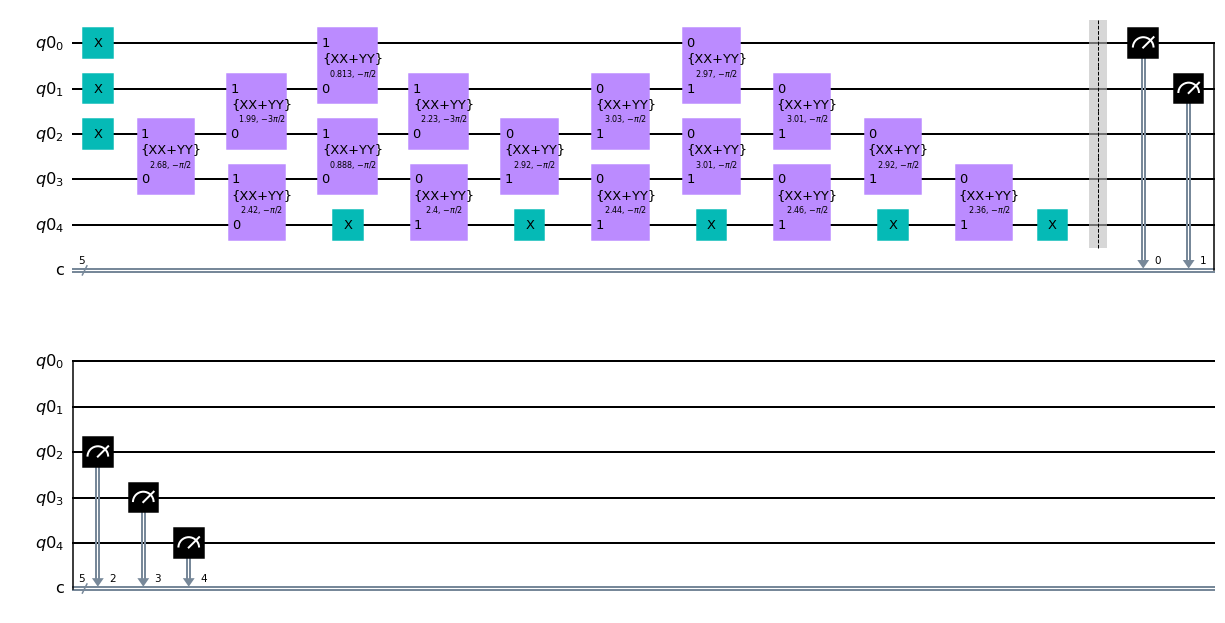

In [13]:
circuit = FermionicGaussianState(transformation_matrix, occupied_orbitals=occupied_orbitals)
circuit.draw("mpl")
# Add measurements
meas = qk.QuantumCircuit(N, N) # N qubits, N classical bits
meas.barrier(range(N)) # the barrier is optional, it is an instruction for the later transpiler
meas.measure(range(N), range(N)) # perform the measurement, record it in the classical bits
circuit.add_register(meas.cregs[0])
qc = circuit.compose(meas)
# Draw the circuit
qc.draw(
    output="mpl", 
    #filename="../fig/example_circuit.pdf"
)

sample from the circuit

In [14]:
# Import Aer and set the backend simulator
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
num_shots = 1000
job_sim = backend_sim.run(
    qk.transpile(qc, backend_sim), 
    shots=num_shots
)
# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(qc)

Estimation of the 1-point and 2-point correlation functions

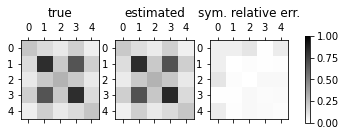

In [15]:
utilities.plot_results(counts,rho_2,num_shots)

In [16]:
# Import Aer and set the backend simulator
from qiskit import Aer
backend_sim = Aer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator, we do several repeats to get 
# the distribution of the TV between the empirical measure and the underlying DPP.
tv_distances = []
num_repeats = 1000
num_shots = 20000
for _ in range(num_repeats):
    
    job_sim = backend_sim.run(
        qk.transpile(qc, backend_sim), 
        shots=num_shots
    )
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    proba, proba_estimated = utilities.get_estimated_probabilities_pfaffian(L,J, counts, num_shots, N)
    tv_distances.append(
        0.5*np.sum([np.abs(proba[key]-proba_estimated[key]) for key in proba])
    )

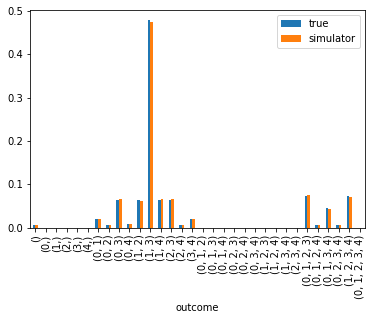

In [17]:
# Let us store the expected and estimated frequencies in a dataframe, 
# which we will complete later on with actual samples from IBMQ machines.
proba_series = pd.Series(proba.values(), index=list(proba.keys()), name="true")
proba_estimated_series = pd.Series(proba_estimated.values(), index=list(proba_estimated.keys()), name="simulator")
proba_series.index.name = "outcome"
proba_estimated_series.index.name = "outcome"
df = pd.merge(proba_series, proba_estimated_series, on="outcome")
#df.plot.bar()
fig = df.plot(kind='bar').get_figure()
fig.savefig("../fig/pfpp1_results.pdf", bbox_inches = 'tight')

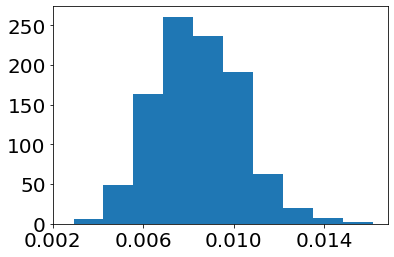

In [18]:
plt.hist(tv_distances)
plt.xticks(fontsize=20)
plt.xticks([0.002, 0.006, 0.010, 0.014])
plt.yticks(fontsize=20)
plt.xticks()
plt.savefig("../fig/pfpp1_tv.pdf")
plt.show()